[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/googlenet/blob/master/googlenet.ipynb)

In [2]:
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 519.5MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59b74000 @  0x7f92af48a1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 3.8MB/s 
    100% |████████████████████████████████| 2.0MB 9.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [1]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse
 from google.colab import auth
 auth.authenticate_user()
 from oauth2client.client import GoogleCredentials
 creds = GoogleCredentials.get_application_default()
 import getpass
 !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
 vcode = getpass.getpass()
 !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import torch
import torchvision
from torch import nn,optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [5]:
transform=transforms.Compose([transforms.ToTensor()])
trainset=datasets.CIFAR10(root='drive/app/cifar',train=True,download=True,transform=transform)
testset=datasets.CIFAR10(root='drive/app/cifar',train=False,download=True,transform=transform)
trainloader=DataLoader(trainset,batch_size=64,num_workers=6,shuffle=True)
testloader=DataLoader(testset,batch_size=64,num_workers=6,shuffle=True)
sizeoftrainset=len(trainset)
sizeoftestset=len(testset)
classes = np.array(('airplane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck'))
if torch.cuda.is_available():
  processor='cuda'
else:
  processor='cpu'
 
device=torch.device(processor)
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda


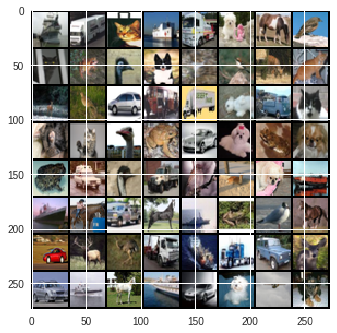

In [6]:

a=iter(trainloader)
def show(image):
  untransform=transforms.ToPILImage()
  plt.figure()
  plt.imshow(untransform(image))
  plt.show()
#showing a sample of dataset  
show(torchvision.utils.make_grid(a.next()[0]))


In [0]:
class inception(nn.Module):
  def __init__(self,in_di1,out_di1,out_di13,out_di3,out_di15,out_di5,max_out):
    super(inception,self).__init__()
    self.conv1=nn.Sequential(
                     nn.Conv2d(in_di1,out_di1,1),
                     nn.BatchNorm2d(out_di1),
                     nn.ReLU(inplace=True)
                  )
    self.conv3=nn.Sequential(
                        nn.Conv2d(in_di1,out_di13,1),
                        nn.BatchNorm2d(out_di13),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(out_di13,out_di3,3,padding=1),
                        nn.BatchNorm2d(out_di3),
                        nn.ReLU(inplace=True)
                    )
    self.conv5=nn.Sequential(
                        nn.Conv2d(in_di1,out_di15,1),
                        nn.BatchNorm2d(out_di15),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(out_di15,out_di5,5,padding=2),
                        nn.BatchNorm2d(out_di5),
                        nn.ReLU(inplace=True)
                    )
    self.maxpool=nn.Sequential(
                        nn.MaxPool2d(3,padding=1,stride=1),
                        nn.Conv2d(in_di1,max_out,1),
                        nn.BatchNorm2d(max_out),
                        nn.ReLU(inplace=True)
                         )
    
  def forward(self,x):
    out1=self.conv1(x)
    out2=self.conv3(x)
    out3=self.conv5(x)
    out4=self.maxpool(x)
    out=torch.cat([out1,out2,out3,out4],dim=1)
    return out
  
  
  
class googlenet(nn.Module):
  def __init__(self):
      super(googlenet,self).__init__()
      self.inlayer=nn.Sequential(
                        nn.Conv2d(3,64,3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(3,padding=1,stride=2)
          
                        )
      self.inc1=inception(64,32,16,64,16,64,64)
      self.inc2=inception(224,64,16,64,16,64,64)
      self.maxpool3=nn.MaxPool2d(3,stride=1)
      self.inc3=inception(256,64,32,96,32,96,64)
      self.inc4=inception(320,96,64,108,64,108,96)
      self.inc5=inception(408,108,96,116,96,116,108)
      self.inc6=inception(448,116,108,148,108,148,148)
      self.maxpool4=nn.MaxPool2d(3,stride=2,padding=1)
      self.inc7=inception(560,148,160,180,160,180,180)
      self.inc8=inception(688,160,170,200,170,200,200)
      self.maxpool5=nn.MaxPool2d(3,stride=2,padding=1)
      self.average=nn.AvgPool2d(4)
      self.linear=nn.Linear(760,10)
      
  def forward(self,x):
      x=self.inlayer(x)
      x=self.inc1(x)
      x=self.inc2(x)
      x=self.maxpool3(x)
      x=self.inc3(x)
      x=self.inc4(x)
      x=self.inc5(x)
      x=self.inc6(x)
      x=self.maxpool4(x)
      x=self.inc7(x)
      x=self.inc8(x)
      x=self.maxpool5(x)
     
      x=self.average(x)
      
      x=x.view(x.size()[0],-1)
      x=self.linear(x)
      return x
                 
      
gnet=googlenet()  
device= 'cuda' if torch.cuda.is_available()else 'cpu'
gnet.to(device)
gnet=nn.DataParallel(gnet)

In [8]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(gnet.parameters(),lr=0.01,momentum=0.9)
scheduler=optim.lr_scheduler.StepLR(optimizer,gamma=0.1,step_size=40)
dtype=torch.cuda.LongTensor
Losslist=[]
num_epoch=70
def train():
 for i in range(num_epoch):
    running_loss=0
    for image,labels in trainloader:
      if device=='cuda':
       labels=labels.type(dtype)
       image.to(device)
       labels.to(device)
      gnet.zero_grad()
      out=gnet(image)
      loss=criterion(out,labels)
      running_loss+=loss
      loss.backward()
      optimizer.step()
    scheduler.step()
    lossofepoch=running_loss/sizeoftrainset
    Losslist.append(running_loss/sizeoftrainset)
    print('running_loss{}:{}'.format(i,lossofepoch))
    
    
train()
  

running_loss0:0.019761934876441956
running_loss1:0.012696143239736557
running_loss2:0.009897839277982712
running_loss3:0.008089021779596806
running_loss4:0.006924051325768232
running_loss5:0.00589288305491209
running_loss6:0.004985895473510027
running_loss7:0.004351120442152023
running_loss8:0.003723371773958206
running_loss9:0.0031776519026607275
running_loss10:0.002703473437577486
running_loss11:0.0023629111237823963
running_loss12:0.0018409278709441423
running_loss13:0.0017832661978900433
running_loss14:0.001529746106825769
running_loss15:0.0013224384747445583
running_loss16:0.0011769455159083009
running_loss17:0.0009188151452690363
running_loss18:0.0009078432922251523
running_loss19:0.0008712747949175537
running_loss20:0.000774356652982533
running_loss21:0.0007134740008041263
running_loss22:0.0004985364503227174
running_loss23:0.0005089051555842161
running_loss24:0.0005619839066639543
running_loss25:0.00041198116377927363
running_loss26:0.0005912398919463158
running_loss27:0.000450

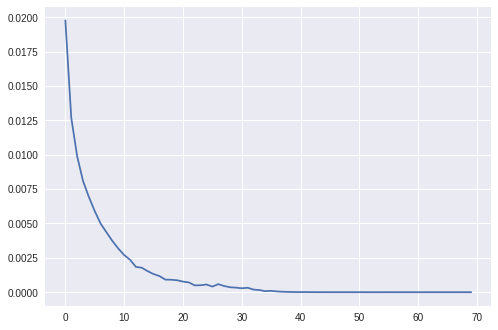

In [9]:
plt.figure()
plt.plot(Losslist)
plt.show()

In [11]:
class_total=np.zeros(10,)
class_correct=np.zeros(10,)

correctsum=0
for i in testloader:
   image,label=i
   label=label.type(dtype)
   image.to(device)
   label.to(device)
   output=gnet(image)
   predict=torch.max(output,1)[1]
   labels=label.cpu().numpy()
   predicts=predict.cpu().numpy()
   unique_elements, counts_elements = np.unique(labels, return_counts=True)
   class_total[unique_elements]+=counts_elements
   correct=(predicts==labels)
   c=[predicts[m] for m,n in enumerate(correct) if n==1]
   uts, cts = np.unique(c, return_counts=True)
   class_correct[uts]+=cts
   correctsum+=correct.sum()
   
print('class accuracy percentage:',class_correct/class_total*100,'\ntotal accuracy:',correctsum/sizeoftestset*100)


class accuracy percentage: [90.1 93.6 82.2 73.8 88.4 81.4 90.7 91.  92.3 93.3] 
total accuracy: 87.68
